# Обработка данных к ВПВ
В работе исследуются три зависимости:
1. Интенсивность поглощения от угла 
2. Величина g-фактора от угла
3. Ширина линии поглощения от угла

## Объявление необходимых библиотек

In [18]:
import pandas as pd 
from scipy.optimize import curve_fit 
import numpy as np
import matplotlib.pyplot as plt

import os

## Пересчет показаний приборов в необходимые величины

Главная подгоночная функция в нашей работе - это функция Лоренца, которая учитывает и дрейф в установке, создающий определенный наклон на графиках, и резонансный пик.

In [19]:
# Функция Лоренца
def lorentzian(x, u0, x0, k, a, b, d): 
    return u0 * (1 + k * x) * (
        1 - a / (1 + ((x - x0) / d) ** 2) + b * (x - x0) / (1 + ((x - x0) / d) ** 2))

def lorentzian_driftless(x, u0, x0, k, a, b, d):
    return u0 * (1 - a / (1 + ((x - x0) / d) ** 2) + b * (x - x0) / (1 + ((x - x0) / d) ** 2)) 

def lor_intens(x, x0, b , d):
    return b / (1 + (x - x0)**2 / d**2) 

def drift_off(x_values, y_values, ampl, slope):
    result = np.empty(len(x_values))
    for i in range(len(y_values)):
        result[i] = y_values[i] / (1 + slope*x_values[i]) / ampl
    return result

В первую очередь избавимся от дрейфа в показаниях.

Отмечу, что дрейф обусловлен луной в казероге и его не должно быть (да уж, тяжела судьба физика-экспериментатора), именно поэтому мы и хотим его убрать.

Замечу, что для 14 ГГц дрейф убрать можно в 4 шага, рассмотрев каждую из 4 ветвей (по 2 слева и справа от резонанса) по отдельности. но делать этого нет особой необходимости, кроме эстетической, поскольку точное значение поглощения мощности излучения нас в этой работе не интересуют. Важен сам факт поглощения при различных частотах при конкретных величинах перменного поля. 

В качестве приближения "на глаз" можно считать, что поглощение составило порядка 15%, 25% и 35% для 9, 11 и 14 ГГц соответственно.

Дрейф для 9 ГГц будет исправлен в первую очередь, чтобы после этого получить полную картину данных.

Fitted parameters:
u0 = 1.0000, x0 = 1.7535e-02, k = 0.0000, a = 0.1352, b = -1.0217, d = -3.6888e-04
/home/golenn/EPR/data_driftless_normalised/driftless 22 9GHz 270degr.dat
Файл 22 9GHz 270degr.dat успешно обработан и сохранён как /home/golenn/EPR/data_driftless_normalised/driftless 22 9GHz 270degr.dat


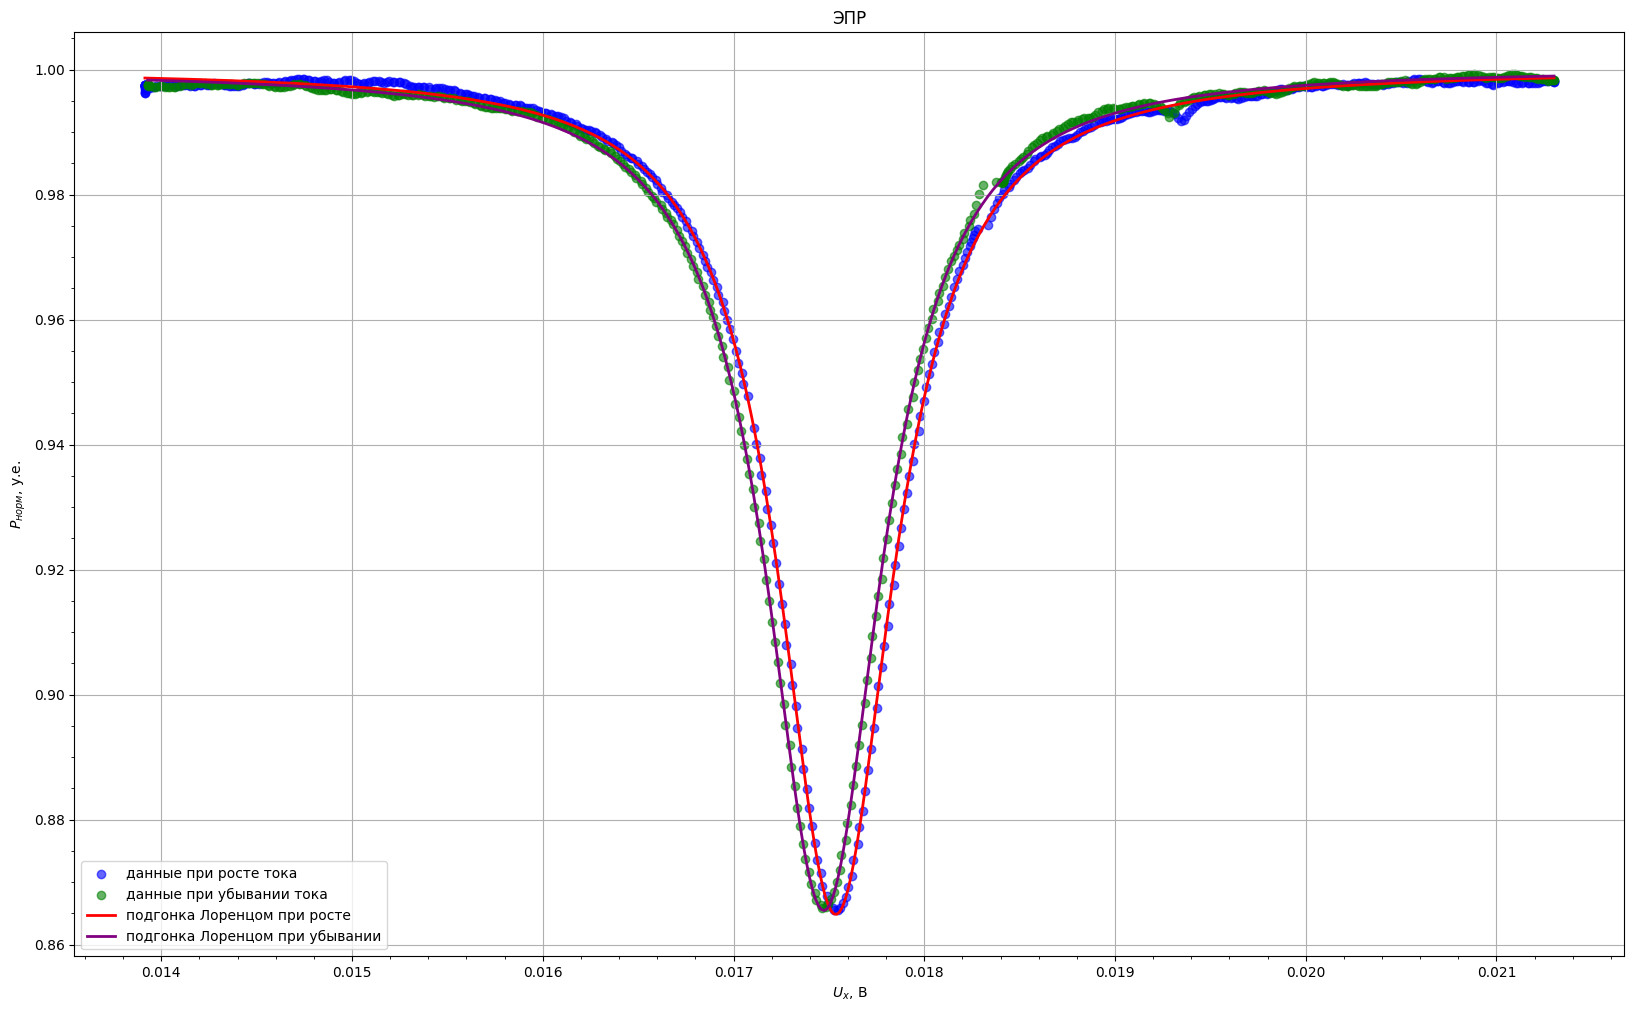

Интерполяционные коэффициенты для возрастания тока:
u0 = 1.0000, x0 = 1.7535e-02, k = 0.0000, a = 0.1352, b = -1.0217, d = -3.6888e-04
Интерполяционные коэффициенты для убывания тока:
u0 = 1.0000, x0 = 1.7477e-02, k = 0.0000, a = 0.1345, b = 6.0521, d = 3.6956e-04


In [57]:
# Считывание данных из файла
file_name = '/home/golenn/EPR/data/22 9GHz 270degr.dat'
file = '22 9GHz 270degr.dat'
output_folder = '/home/golenn/EPR/data_driftless_normalised/'

data = pd.read_csv(file_name, skiprows=3, sep='\t')
data.columns = ["X_channel", "Y_channel", "II_channel", "timestamp"]
x_data = data["X_channel"].values
y_data = data["Y_channel"].values

# Нормировка по Y для возрастания и убывания тока
x_idx_max = np.argmax(x_data)

y_max = max(y_data)
for i in range(len(y_data)):
    y_data[i] = y_data[i] / y_max 

y1_data = y_data[:x_idx_max]
x1_data = x_data[:x_idx_max]
y2_data = y_data[x_idx_max:]
x2_data = x_data[x_idx_max:]

# Начальные приближения параметров для случаев возрастания и убывания тока
u0_guess_1, u0_guess_2 = 1, 0.98
x0_guess_1 = x1_data[np.argmax(y1_data)]
x0_guess_2 = x2_data[np.argmax(y2_data)]
initial_guess_1 = [u0_guess_1, x0_guess_1, 1, 0.1, 0.1, 0.1]
initial_guess_2 = [u0_guess_2, x0_guess_2, -2, 0.1, 0.1, 0.1]

# Подбор параметров для случаев возрастания и убывания тока
params1, params_cov1 = curve_fit(lorentzian, x1_data, y1_data, p0=initial_guess_1)
params2, params_cov2 = curve_fit(lorentzian, x2_data, y2_data, p0=initial_guess_2)

k1 = params1[2]
u0_1 = params1[0]

k2 = params2[2]
u0_2 = params2[0]

# Подгонка каждой точки к значению без дрейфа
y1_data = drift_off(x1_data, y1_data, u0_1, k1)
params1[0] = 1
params1[2] = 0

y2_data = drift_off(x2_data, y2_data, u0_2, k2)
params2[0] = 1
params2[2] = 0

print("Fitted parameters:")
print(f"u0 = {params1[0]:.4f}, x0 = {params1[1]:.4e}, k = {params1[2]:.4f}, "
    f"a = {params1[3]:.4f}, b = {params1[4]:.4f}, d = {params1[5]:.4e}")


data["Y_channel"] = np.concatenate([y1_data, y2_data])

output_file_path = os.path.join(output_folder, f"driftless {file}")
print(output_file_path)
data.to_csv(output_file_path, sep=' ', index=False)
print(f"Файл {file} успешно обработан и сохранён как {output_file_path}")


# Генерация кривых для графика
x_fit1 = np.linspace(min(x1_data), max(x1_data), 500)
y_fit1 = lorentzian(x_fit1, *params1)
x_fit2 = np.linspace(min(x2_data), max(x2_data), 500)
y_fit2 = lorentzian(x_fit2, *params2)

# Построение графика
plt.figure(figsize=(20, 12))
plt.scatter(x1_data, y1_data, color='blue', label='данные при росте тока', alpha=0.6)
plt.scatter(x2_data, y2_data, color='green', label='данные при убывании тока', alpha=0.6)
plt.plot(x_fit1, y_fit1, color='red', label='подгонка Лоренцом при росте', linewidth=2)
plt.plot(x_fit2, y_fit2, color='purple', label='подгонка Лоренцом при убывании', linewidth=2)
plt.title('ЭПР')

plt.ylabel(r'$P_{норм}$, у.е.')
plt.xlabel(r'$U_{х}$, В')

plt.legend()
plt.grid()
plt.minorticks_on()
#plt.grid('minor', 'both')
plt.savefig(fname='EPR 9 GHz')
plt.show()
# Вывод параметров
print("Интерполяционные коэффициенты для возрастания тока:")
print(f"u0 = {params1[0]:.4f}, x0 = {params1[1]:.4e}, k = {params1[2]:.4f}, "
      f"a = {params1[3]:.4f}, b = {params1[4]:.4f}, d = {params1[5]:.4e}")

print("Интерполяционные коэффициенты для убывания тока:")
print(f"u0 = {params2[0]:.4f}, x0 = {params2[1]:.4e}, k = {params2[2]:.4f}, "
      f"a = {params2[3]:.4f}, b = {params2[4]:.4f}, d = {params2[5]:.4e}")


Ниже посмотрим на все данные, но с неправильными данными 9 ГГц в силу исторических причин.

['01 11GHz 270degr.dat', '02 11GHz 270degr.dat', '03 11GHz 000degr.dat', '04 11GHz 350degr.dat', '05 11GHz 340degr.dat', '06 11GHz 330degr.dat', '07 11GHz 320degr.dat', '08 11GHz 310degr.dat', '09 11GHz 300degr.dat', '10 11GHz 290degr.dat', '11 11GHz 280degr.dat', '12 11GHz 270degr.dat', '13 11GHz 260degr.dat', '14 11GHz 250degr.dat', '15 11GHz 240degr.dat', '16 11GHz 230degr.dat', '17 11GHz 230degr.dat', '18 11GHz 220degr.dat', '19 11GHz 210degr.dat', '20 11GHz 200degr.dat', '21 11GHz 010degr.dat', '22 9GHz 270degr.dat', '23 14GHz 270degr.dat']
Fitted parameters:
u0 = 3344.8173, x0 = 2.1144e-02, k = -1.8998, a = 0.2447, b = 120.6029, d = -4.7178e-04
Файл 01 11GHz 270degr.dat успешно обработан и сохранён как /home/golenn/EPR/data_driftless_normalised/driftless 01 11GHz 270degr.dat
Fitted parameters:
u0 = 3526.5269, x0 = -7.6053e-02, k = 0.2281, a = 0.0770, b = 0.2086, d = -8.7256e+00
Файл 02 11GHz 270degr.dat успешно обработан и сохранён как /home/golenn/EPR/data_driftless_normalised/d

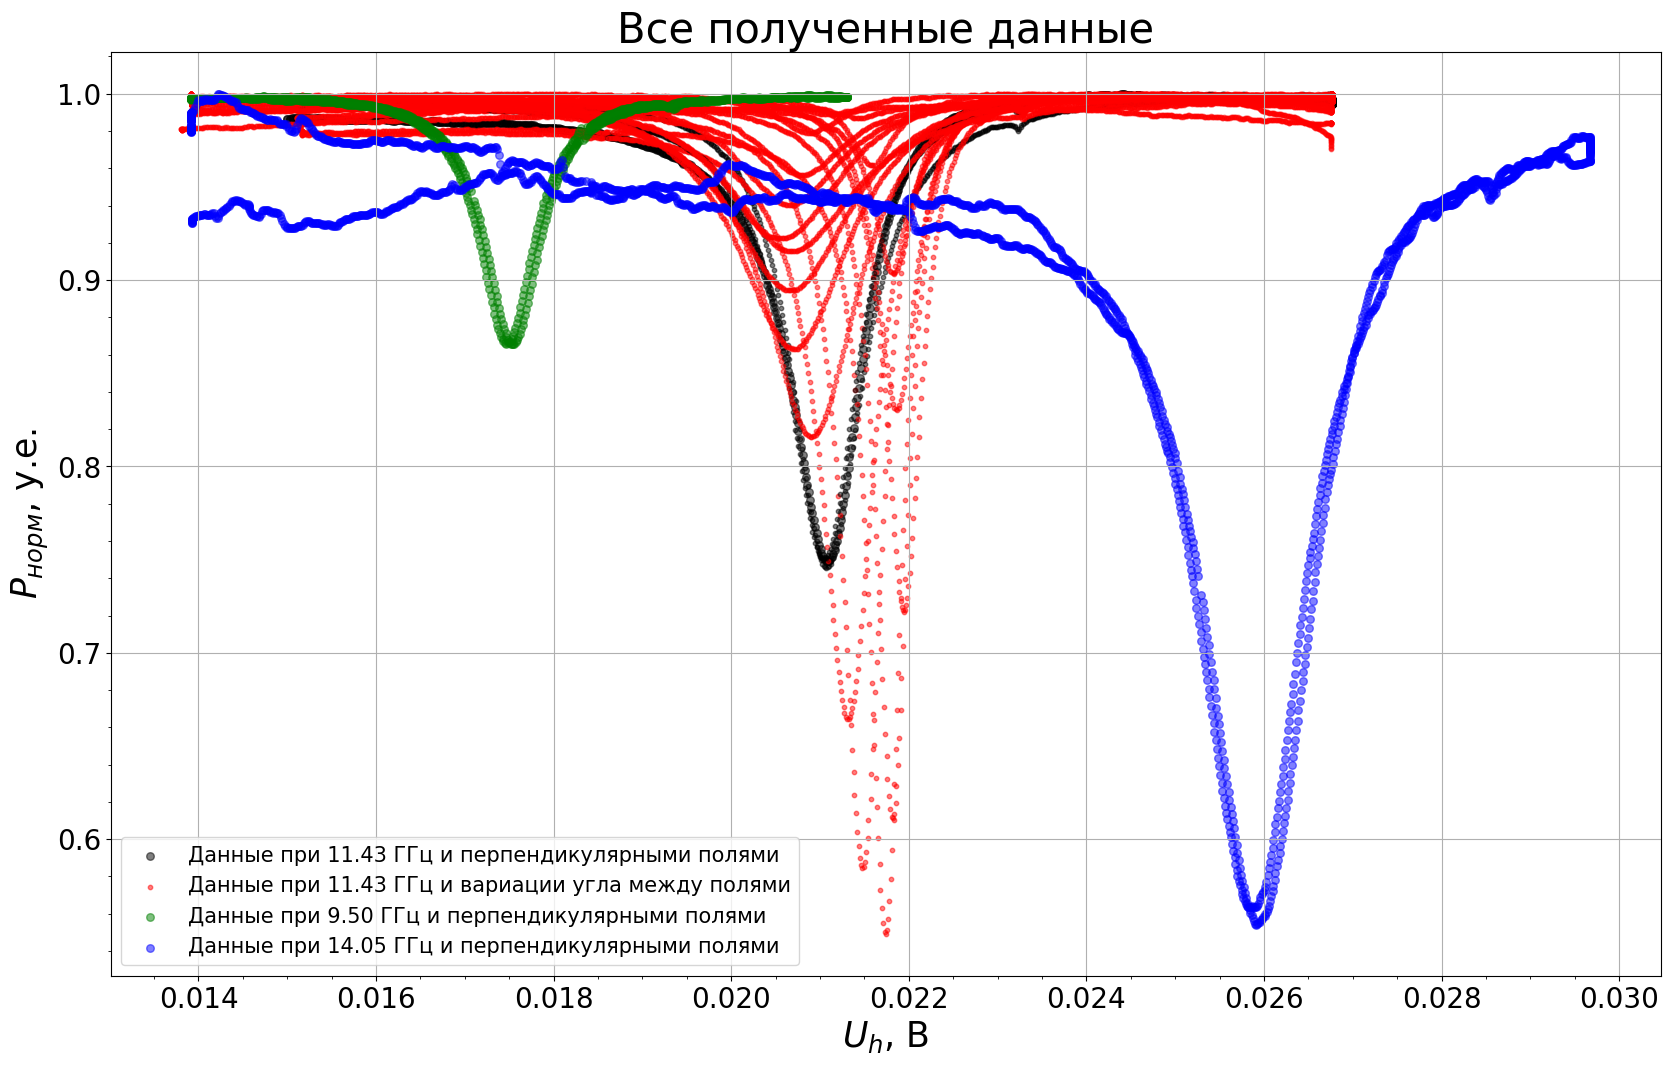

In [82]:
# Объявление путей директорий с файлами 
input_folder = '/home/golenn/EPR/data/'
output_folder = '/home/golenn/EPR/data_driftless_normalised/'
#os.makedirs(output_folder, exist_ok=True)

plt.figure(figsize=(20, 12))
plt.title('Все полученные данные', fontsize=30)
plt.ylabel(r'$P_{норм}$, у.е.', fontsize=25)
plt.xlabel(r'$U_h$, В', fontsize=25)


my_color = ['blue', 'red', 'green']
clr = ''

files = os.listdir(input_folder)
files.sort()
print(files)

for file_name in files:
    input_file_path = os.path.join(input_folder, file_name)
    output_file_path = os.path.join(output_folder, f"driftless {file_name}")
    
    # Загрузка данных
    df = pd.read_csv(input_file_path, skiprows=3, sep='\t')
    df.columns = ["X_channel", "Y_channel", "II_channel", "timestamp"]
    x_data = df["X_channel"].values
    y_data = df["Y_channel"].values

    # В наших данных нет пропущенных ячеек, поэтому лишний код на проверку этого не пишем
    if '22 ' in file_name:
        print(f'\n aoaoaooaoaao \n {output_file_path} \n aoaoaoaoaoao \n')
        data = pd.read_csv('/home/golenn/EPR/data_driftless_normalised/driftless 22 9GHz 270degr.dat', skiprows=3, sep=' ')
        data.columns = ["X_channel", "Y_channel", "II_channel", "timestamp"]
        x_data_9ghz = data["X_channel"].values
        y_data_9ghz = data["Y_channel"].values
        plt.scatter(x_data_9ghz, y_data_9ghz, color='green', label=f'Данные при 9.50 ГГц и перпендикулярными полями', alpha=0.5, s=30)
        continue

    try:
        # Начальные приближения параметров
        if '14GHz' in file_name: # сильный разброс, поэтому лучше сразу отнормировать по максимуму
            #y_data /= np.max(y_data)
            #print('norm')
            clr = my_color[0]
        else:
            clr = my_color[1]
        #if '310' in file_name:
        #    clr = 'black'

        if '270' in file_name and '11GHz' in file_name:
            clr = 'black'
        
        u0_guess = (y_data[0] + y_data[len(y_data)-1])/2
        x0_guess = x_data[np.argmin(y_data)]
        initial_guess = [u0_guess, x0_guess, -1, 0.1, 0.1, 0.1]

        # Подбор параметров
        params, params_cov = curve_fit(lorentzian, x_data, y_data, p0=initial_guess)
        k = params[2]
        u0 = params[0]

        # Подгонка каждой точки к значению без дрейфа
        df["Y_channel"] = drift_off(x_data, y_data, params[0], params[2])
        y_data = df["Y_channel"].values
        df["Y_channel"] /= np.max(y_data)

        print("Fitted parameters:")
        print(f"u0 = {params[0]:.4f}, x0 = {params[1]:.4e}, k = {params[2]:.4f}, "
            f"a = {params[3]:.4f}, b = {params[4]:.4f}, d = {params[5]:.4e}")

        df.to_csv(output_file_path, sep=' ', index=False)
        print(f"Файл {file_name} успешно обработан и сохранён как {output_file_path}")

    except Exception:
        print('Exception raised')
        y_data = df["Y_channel"].values
        df["Y_channel"] /= np.max(y_data) # curve_fit не смог посчитать, конкретное исключение лень писать
    
    
        df.to_csv(output_file_path, sep=' ', index=False)
        print(f"Файл {file_name} успешно обработан и сохранён как {output_file_path}")

    # Построение графика
    if '01 ' in file_name:
        plt.scatter(x_data, y_data, color=clr, label=f'Данные при 11.43 ГГц и перпендикулярными полями', alpha=0.5, s=30)  
    elif '23 ' in file_name:
        plt.scatter(x_data, y_data, color=clr, label=f'Данные при 14.05 ГГц и перпендикулярными полями', alpha=0.5, s=30)    
    elif '17 ' in file_name:
        plt.scatter(x_data, y_data, color=clr, label=f'Данные при 11.43 ГГц и вариации угла между полями', alpha=0.5, s=10)
    else:
        plt.scatter(x_data, y_data, color=clr, alpha=0.5, s=10)

    
    
plt.legend(fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid()
plt.minorticks_on()

plt.savefig(fname='Data')
plt.show()



После того, как мы убрали дрейф, можем пересчитать снимаемые с приборов величины в те, что удобно интерпретировать с точки зрения теории.

**По оси X** - напряжение на датчике Холла, прикрепленном к полюсу магнита. Поле на полюсе отличается (в пределах 10%) от поля в центре, но они пропорциональны друг другу (линейность уравнений Максвелла). 

При помощи метки ДФПГ мы найдем коэффициент пересчёта между этими милливольтами и килогауссами/килоэрстедами.

**По оси Y** - напряженеи на детекторе, пропорциональное мощности сигнала, прошедшего через резонатор. Точнее - при помощи синхронного детектора  измеряем абсолютную амплитуду (фазу не учитываем) первой гармоники ни частоте амплитудной модуляции меандром с глубиной 100%. Частота модуляции - около 1 кГц. Создаётся внешним генератором меандра, синхронизованным с синхронным детектором и, для наглядности, с осциллографом.


# обработка пиков 270*

Ниже представлен график ЭПР при перпендикулярных полях при 9, 11 и 14 ГГц соответственно.

['driftless 01 11GHz 270degr.dat', 'driftless 02 11GHz 270degr.dat', 'driftless 03 11GHz 000degr.dat', 'driftless 04 11GHz 350degr.dat', 'driftless 05 11GHz 340degr.dat', 'driftless 06 11GHz 330degr.dat', 'driftless 07 11GHz 320degr.dat', 'driftless 08 11GHz 310degr.dat', 'driftless 09 11GHz 300degr.dat', 'driftless 10 11GHz 290degr.dat', 'driftless 11 11GHz 280degr.dat', 'driftless 12 11GHz 270degr.dat', 'driftless 13 11GHz 260degr.dat', 'driftless 14 11GHz 250degr.dat', 'driftless 15 11GHz 240degr.dat', 'driftless 16 11GHz 230degr.dat', 'driftless 17 11GHz 230degr.dat', 'driftless 18 11GHz 220degr.dat', 'driftless 19 11GHz 210degr.dat', 'driftless 20 11GHz 200degr.dat', 'driftless 21 11GHz 010degr.dat', 'driftless 22 9GHz 270degr.dat', 'driftless 23 14GHz 270degr.dat']
driftless 01 11GHz 270degr.dat
Fitted parameters:
u0 = 0.9947, x0 = 2.1144e-02, y0 = 0.7490354819027508 , k = -0.0080, a = 0.2447, b = 120.7516, d = 4.7190e-04
driftless 02 11GHz 270degr.dat
Fitted parameters:
u0 = 0.9

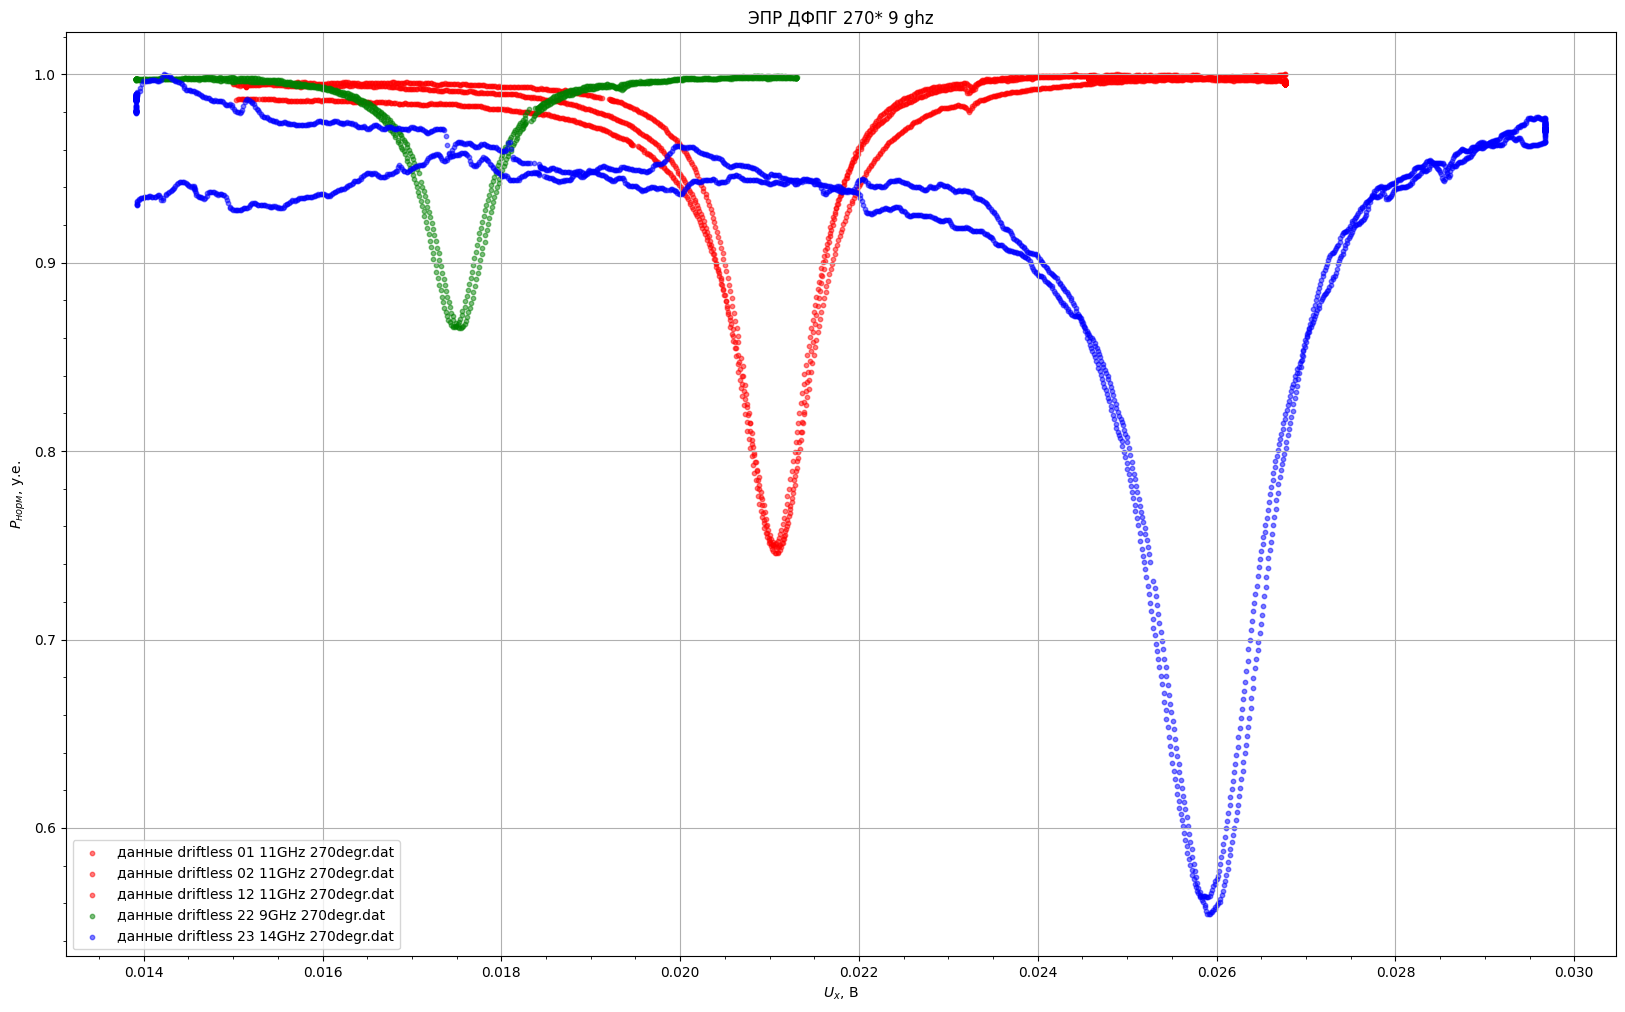

In [84]:
# Объявление путей директорий с файлами 
input_folder = '/home/golenn/EPR/data_driftless_normalised/'

plt.figure(figsize=(20, 12))
plt.title('ЭПР ДФПГ 270* 9 ghz')
plt.ylabel(r'$P_{норм}$, у.е.')
plt.xlabel(r'$U_{х}$, В')


my_color = ['blue', 'red', 'green']
flag = 0
files = os.listdir(input_folder)
files.sort()
print(files)

x0 = []
d = []

for file_name in files:
    if '270' in file_name:
        print(file_name)
        input_file_path = os.path.join(input_folder, file_name)    
        # Загрузка данных
        df = pd.read_csv(input_file_path, skiprows=3, sep=' ')
        df.columns = ["X_channel", "Y_channel", "II_channel", "timestamp"]
        x_data_all = df["X_channel"].values
        y_data_all = df["Y_channel"].values

        x_data = x_data_all#[np.argmin(y_data_all):]
        y_data = y_data_all#[np.argmin(y_data_all):]
    # В наших данных нет пропущенных ячеек, поэтому лишний код на проверку этого не пишем
    
        try:
            # Начальные приближения параметров
            if '14GHz' in file_name: # сильный разброс, поэтому лучше сразу отнормировать по максимуму
                #y_data /= np.max(y_data)
                #print('norm')
                clr = my_color[0]
            elif '11GHz' in file_name:
                clr = my_color[1]
            else:
                clr = my_color[2]
            
            u0_guess = (y_data[0] + y_data[len(y_data)-1])/2
            x0_guess = x_data[np.argmax(y_data)]
            initial_guess = [u0_guess, x0_guess, -1, 0.1, 0.1, 0.1]

            # Подбор параметров
            params, params_cov = curve_fit(lorentzian, x_data, y_data, p0=initial_guess)
            k = params[2]
            u0 = params[0]

            # Подгонка каждой точки к значению без дрейфа
            #y_data = drift_off(x_data, y_data, params[0], params[2])

            print("Fitted parameters:")
            print(f"u0 = {params[0]:.4f}, x0 = {params[1]:.4e}, y0 = {np.min(y_data)} , k = {params[2]:.4f}, "
                f"a = {params[3]:.4f}, b = {params[4]:.4f}, d = {params[5]:.4e}")
            
            # Генерация кривой для графика
            x_fit = np.linspace(min(x_data), max(x_data), 500)
            y_fit = lorentzian_driftless(x_fit, *params)

        except Exception:
            print(f'Exception raised {file_name}')
            #y_data = y_data / np.max(y_data) # curve_fit не смог посчитать, конкретное исключение лень писать
  
        # Построение графика
        plt.scatter(x_data, y_data, color=clr, label=f'данные {file_name}', alpha=0.5, s=10)
        #plt.scatter(x_data[np.argmax(x_data):], y_data[np.argmax(x_data):], color='green', label='данные', alpha=0.6)
        #plt.plot(x_fit, y_fit, color='red', label='подгонка Лоренцом', linewidth=2)
        
        # Вывод параметров
    
    
plt.legend()
plt.grid()
plt.minorticks_on()
plt.show()

    #plt.savefig(fname='EPR 9 GHz')


Проанализируем набор данных из каждого эксперимента по отдельности

['driftless 01 11GHz 270degr.dat', 'driftless 02 11GHz 270degr.dat', 'driftless 03 11GHz 000degr.dat', 'driftless 04 11GHz 350degr.dat', 'driftless 05 11GHz 340degr.dat', 'driftless 06 11GHz 330degr.dat', 'driftless 07 11GHz 320degr.dat', 'driftless 08 11GHz 310degr.dat', 'driftless 09 11GHz 300degr.dat', 'driftless 10 11GHz 290degr.dat', 'driftless 11 11GHz 280degr.dat', 'driftless 12 11GHz 270degr.dat', 'driftless 13 11GHz 260degr.dat', 'driftless 14 11GHz 250degr.dat', 'driftless 15 11GHz 240degr.dat', 'driftless 16 11GHz 230degr.dat', 'driftless 17 11GHz 230degr.dat', 'driftless 18 11GHz 220degr.dat', 'driftless 19 11GHz 210degr.dat', 'driftless 20 11GHz 200degr.dat', 'driftless 21 11GHz 010degr.dat', 'driftless 22 9GHz 270degr.dat', 'driftless 23 14GHz 270degr.dat']
driftless 23 14GHz 270degr.dat
Fitted parameters:
u0 = 3.6408, x0 = 3.6228e-02, y0 = 0.9455129199425446 , k = -23.4095, a = -0.3665, b = 75.1879, d = -2.3125e+02
0.02859441 0.9455129199425446


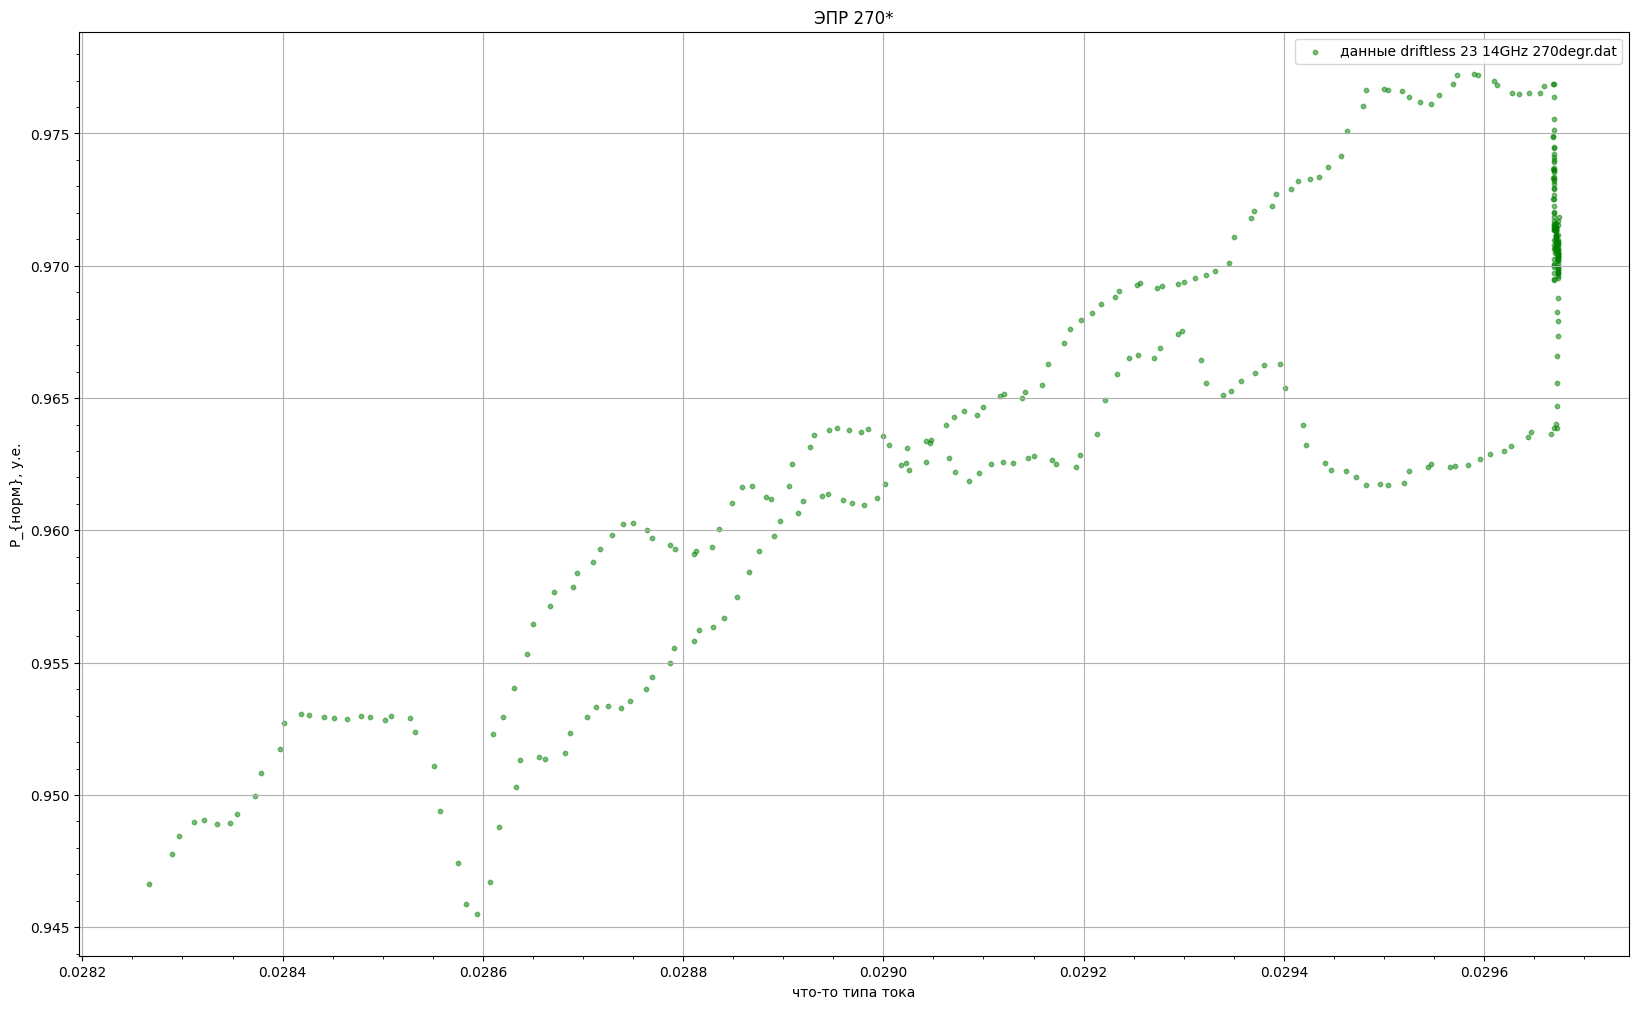

In [23]:
# Объявление путей директорий с файлами 
input_folder = '/home/golenn/EPR/data_driftless_normalised/'

plt.figure(figsize=(20, 12))
plt.title('ЭПР 270*')
plt.ylabel(r'P_{норм}, у.е.')
plt.xlabel(r'что-то типа тока')

my_color = ['blue', 'red', 'green']
flag = 0
files = os.listdir(input_folder)
files.sort()
print(files)

x0 = []
d = []

for file_name in files:
    if '23 ' in file_name: # нужно рассмотреть 01 02 12 22 23 файлы
        print(file_name)
        input_file_path = os.path.join(input_folder, file_name)    
        # Загрузка данных
        df = pd.read_csv(input_file_path, skiprows=3, sep=' ')
        df.columns = ["X_channel", "Y_channel", "II_channel", "timestamp"]
        x_data_all = df["X_channel"].values
        y_data_all = df["Y_channel"].values

        if x_data_all[0] < 0.02:
            x_data_all = x_data_all[::-1]
            y_data_all = y_data_all[::-1]

        x_data = x_data_all[1155:1500]
        y_data = y_data_all[1155:1500]

        #print(f'x = {x_data[np.argmin(y_data)]}', f'y = {np.min(y_data)} ')
        '''
        x_data = []
        y_data = []
        for x in x_data_temp:
            if (x > 0.019) and (x < 0.0197):
                x_data.append(x)
                y_data.append(y_data_temp[np.])
                              
        np.array(x_data)
        np.array(y_data)
        '''
    # В наших данных нет проп/home/golenn/EPR/data_driftless_normalised/22 9GHz 270degr.datущенных ячеек, поэтому лишний код на проверку этого не пишем
    
        try:
            # Начальные приближения параметров
            if '01 ' in file_name: # сильный разброс, поэтому лучше сразу отнормировать по максимуму
                #y_data /= np.max(y_data)
                #print('norm')
                clr = my_color[0]
            elif '02 ' in file_name:
                clr = my_color[1]
            else:
                clr = my_color[2]
            
            u0_guess = (y_data[0] + y_data[len(y_data)-1])/2
            x0_guess = x_data[np.argmax(y_data)]
            initial_guess = [u0_guess, x0_guess, -1, 0.1, 0.1, 0.1]

            # Подбор параметро500:1500в
            params, params_cov = curve_fit(lorentzian, x_data, y_data, p0=initial_guess)
            k = params[2]
            u0 = params[0]

            print("Fitted parameters:")
            print(f"u0 = {params[0]:.4f}, x0 = {params[1]:.4e}, y0 = {np.min(y_data)} , k = {params[2]:.4f}, "
                f"a = {params[3]:.4f}, b = {params[4]:.4f}, d = {params[5]:.4e}")
            
            # Генерация кривой для графика
            x_fit = np.linspace(min(x_data), max(x_data), 500)
            y_fit = lorentzian_driftless(x_fit, *params)

        except Exception:
            print(f'Exception raised {file_name}')
            #y_data = y_data / np.max(y_data) # curve_fit не смог посчитать, конкретное исключение лень писать
  
        # Построение графикаarg
        plt.scatter(x_data, y_data, color=clr, label=f'данные {file_name}', alpha=0.5, s=10)
        print(x_data[np.argmin(y_data)], np.min(y_data))
        #plt.scatter(x_data[np.argmax(x_data):], y_data[np.argmax(x_data):], color='green', label='данные', alpha=0.6)
        #plt.plot(x_fit, y_fit, color='red', label='подгонка Лоренцом', linewidth=2)
        
        # Вывод параметров
    
    
plt.legend()
plt.grid()
plt.minorticks_on()
plt.show()

    #plt.savefig(fname='EPR 9 GHz')


Ниже собраны все данные пиков 

In [24]:
peaks_9GHz_x = [0.01934, 0.01928]
peaks_9GHz_y = [0.98158, 0.98782]
peaks_11GHz_x = [0.02322941, 0.02322989, 0.02327899]  
peaks_11GHz_y = [0.98022290246757, 0.99015459622291, 0.991480080539994]
peaks_14GHz_x = [0.02854749, 0.02859441]  
peaks_14GHz_y = [0.9431778307503448, 0.9455129199425446]

U_h = peaks_9GHz_x + peaks_11GHz_x + peaks_14GHz_x
B_0 = [2.8/9.503]*2 + [2.8/11.43]*3 + [2.8/14.052]*2

<>:11: SyntaxWarning: invalid escape sequence '\c'
<>:11: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_53801/3786600010.py:11: SyntaxWarning: invalid escape sequence '\c'
  plt.plot(U_h, ya, color='r', label=f'$B = -10.17\cdot U_h + 0.49$')


[-10.17348218   0.48663268]


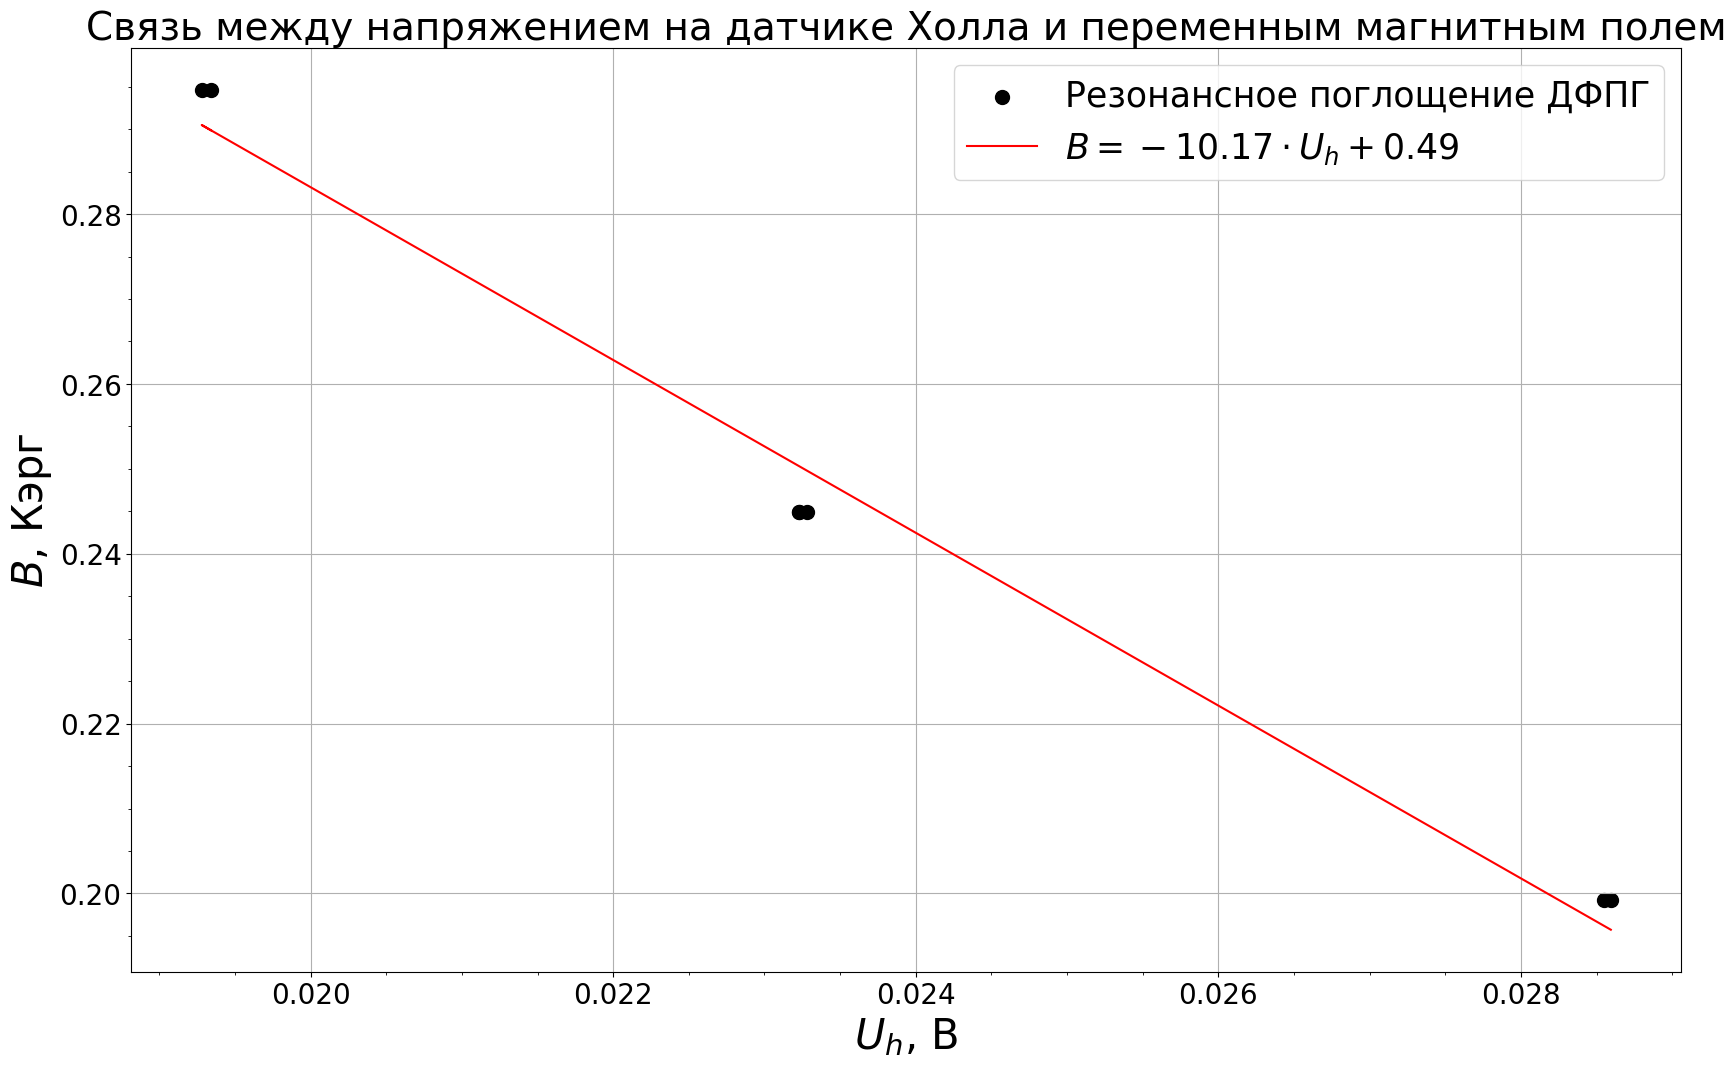

In [25]:
p = np.polyfit(U_h, B_0, 1)
ya = np.polyval(p, U_h)
print(p)

plt.figure(figsize=(20, 12))
plt.title('Связь между напряжением на датчике Холла и переменным магнитным полем', fontsize=28)
plt.ylabel(r'$B$, Кэрг', fontsize=30)
plt.xlabel(r'$U_h$, В', fontsize=30)

plt.scatter(U_h, B_0, color='black', label=f'Резонансное поглощение ДФПГ', s=100)
plt.plot(U_h, ya, color='r', label=f'$B = -10.17\cdot U_h + 0.49$')

plt.legend(fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid()
plt.minorticks_on()

plt.savefig(fname='B(U)')
plt.show()


## Визуализация для одного положения при разных частотах

driftless 01 11GHz 270degr.dat
Интерполяционные коэффициенты для возрастания тока:
u0 = 0.9945, x0 = 2.1144e-02, k = 0.0000, a = 0.2448, b = 120.5154, d = 4.7182e-04
driftless 02 11GHz 270degr.dat
Интерполяционные коэффициенты для возрастания тока:
u0 = 0.9994, x0 = 2.1074e-02, k = 0.0000, a = 0.2546, b = -15.9296, d = -4.8071e-04
driftless 12 11GHz 270degr.dat
Интерполяционные коэффициенты для возрастания тока:
u0 = 0.9990, x0 = 2.1069e-02, k = 0.0000, a = 0.2496, b = 61.1683, d = 4.7590e-04


/tmp/ipykernel_53801/2524737706.py:33: OptimizeWarning: Covariance of the parameters could not be estimated
  params1, params_cov1 = curve_fit(lorentzian_driftless, x1_data, y1_data, p0=initial_guess_1)
/tmp/ipykernel_53801/2524737706.py:33: OptimizeWarning: Covariance of the parameters could not be estimated
  params1, params_cov1 = curve_fit(lorentzian_driftless, x1_data, y1_data, p0=initial_guess_1)
/tmp/ipykernel_53801/2524737706.py:33: OptimizeWarning: Covariance of the parameters could not be estimated
  params1, params_cov1 = curve_fit(lorentzian_driftless, x1_data, y1_data, p0=initial_guess_1)


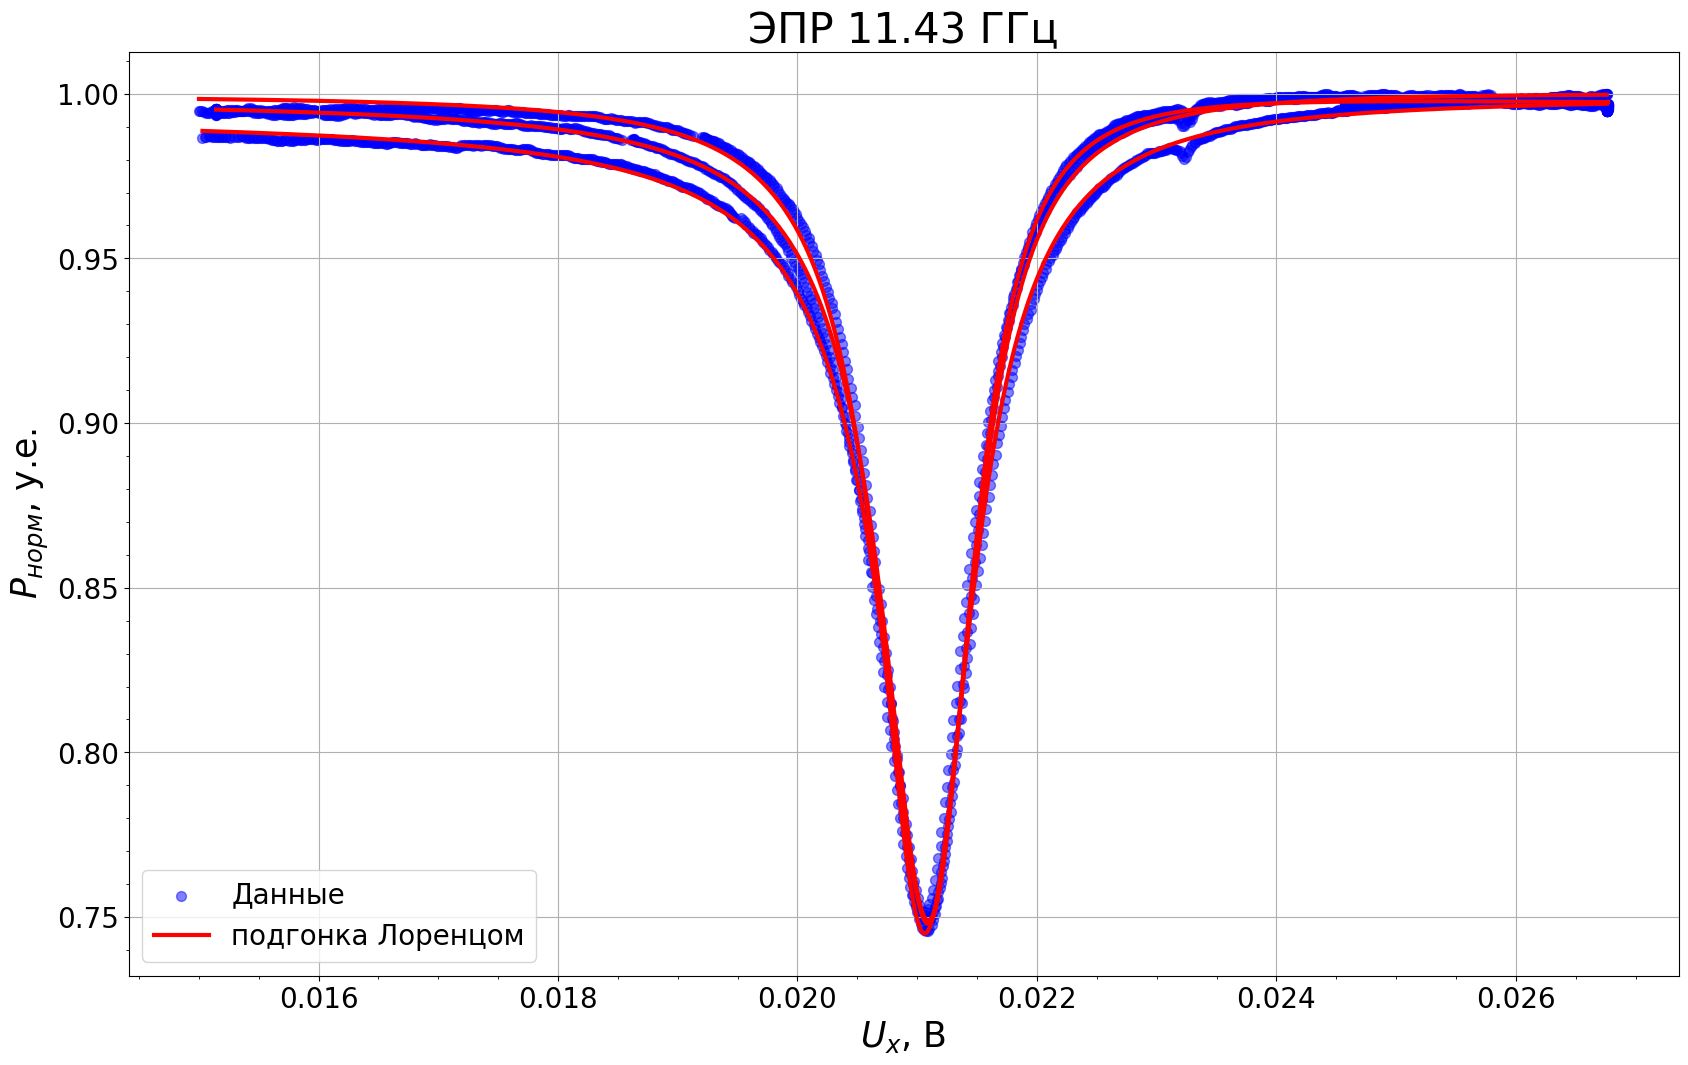

In [98]:
# Объявление путей директорий с файлами 
input_folder = '/home/golenn/EPR/data_driftless_normalised/'

# Построение графика
plt.figure(figsize=(20, 12))
plt.title('ЭПР 11.43 ГГц', fontsize = 30)
plt.ylabel(r'$P_{норм}$, у.е.',fontsize=25)
plt.xlabel(r'$U_{х}$, В',fontsize=25)

flag = 0
files = os.listdir(input_folder)
files.sort()
#print(files)

for file_name in files:
      if '270' in file_name and '11' in file_name:
        
            print(file_name)
            input_file_path = os.path.join(input_folder, file_name)    
            # Загрузка данных
            df = pd.read_csv(input_file_path, skiprows=3, sep=' ')
            df.columns = ["X_channel", "Y_channel", "II_channel", "timestamp"]
            x1_data = df["X_channel"].values
            y1_data = df["Y_channel"].values
    
            try:
                  # Начальные приближения параметров для случаев возрастания и убывания тока
                  u0_guess_1 = 1
                  x0_guess_1 = x1_data[np.argmax(y1_data)]
                  initial_guess_1 = [u0_guess_1, x0_guess_1, 0, 0.1, 0.1, 0.1]

                  # Подбор параметров для случаев возрастания и убывания тока
                  params1, params_cov1 = curve_fit(lorentzian_driftless, x1_data, y1_data, p0=initial_guess_1)

                  # Вывод параметров
                  print("Интерполяционные коэффициенты для возрастания тока:")
                  print(f"u0 = {params1[0]:.4f}, x0 = {params1[1]:.4e}, k = {params1[2]:.4f}, "
                        f"a = {params1[3]:.4f}, b = {params1[4]:.4f}, d = {params1[5]:.4e}")

                  # Генерация кривых для графика
                  x_fit = np.linspace(min(x1_data), max(x1_data), 500)
                  y_fit = lorentzian_driftless(x_fit1, *params1)

            except Exception:
                  print(f'Exception raised {file_name}')
            
  
            # Построение графика
            if '01' in file_name:
                  plt.scatter(x1_data, y1_data, color='b', label=f'Данные', alpha=0.5, s=50)
                  plt.plot(x_fit, y_fit, color='r', label='подгонка Лоренцом', linewidth=3)
            else:
                  plt.scatter(x1_data, y1_data, color='b', alpha=0.5, s=50)
                  plt.plot(x_fit, y_fit, color='r', linewidth=3)
    

plt.legend(fontsize=20)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)
plt.minorticks_on()
plt.savefig(fname='EPR 11 GHz')
plt.show()


отдельный просчет для 14 ГГц, тк разный дрейф при увелечении и уменьшении тока 

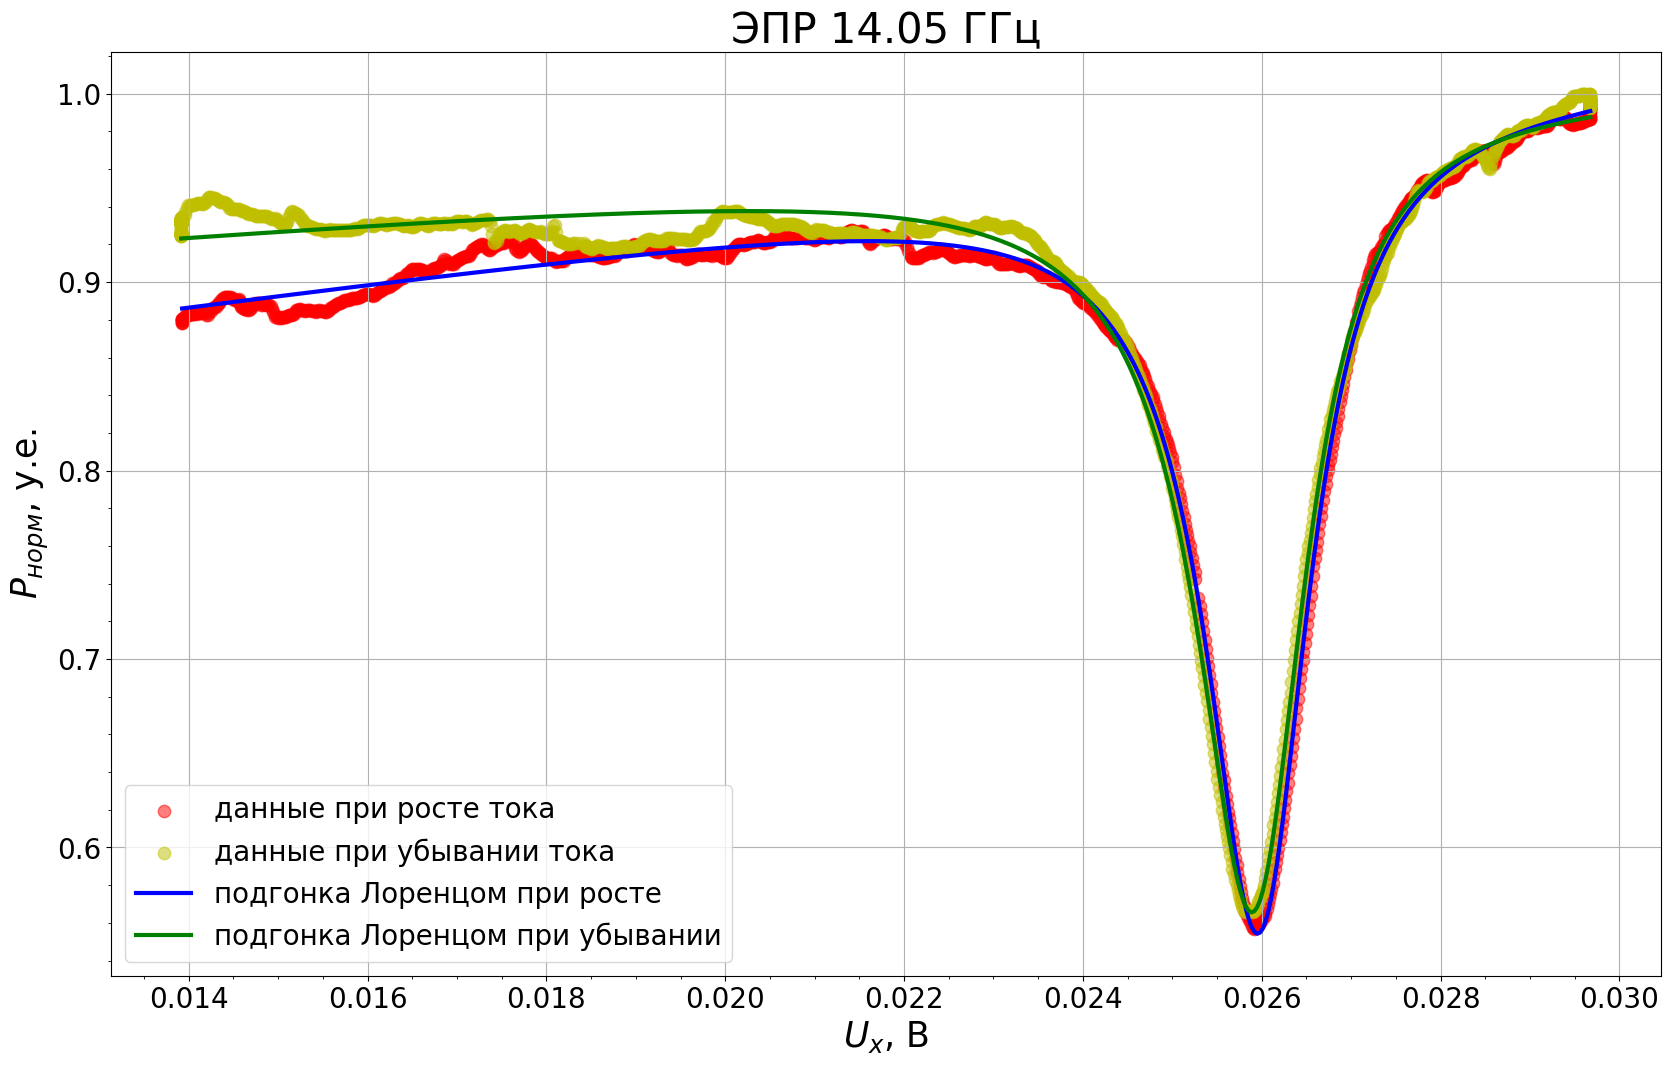

Интерполяционные коэффициенты для возрастания тока:
u0 = 0.7989, x0 = 2.6008e-02, k = 8.2462, a = 0.4262, b = 89.1212, d = 7.0821e-04
Интерполяционные коэффициенты для убывания тока:
u0 = 0.8751, x0 = 2.5954e-02, k = 4.4056, a = 0.4168, b = 97.9485, d = -7.4283e-04


In [83]:
# Считывание данных из файла
filename = '/home/golenn/EPR/data/23 14GHz 270degr.dat'
data = pd.read_csv(filename, skiprows=3, sep='\t')
data.columns = ["X_channel", "Y_channel", "II_channel", "timestamp"]
x_data = data["X_channel"].values
y_data = data["Y_channel"].values

# Нормировка по Y для возрастания и убывания тока
x_idx_max = np.argmax(x_data)

y_max = max(y_data)
for i in range(len(y_data)):
    y_data[i] = y_data[i] / y_max 

y1_data = y_data[:x_idx_max]
x1_data = x_data[:x_idx_max]
y2_data = y_data[x_idx_max:]
x2_data = x_data[x_idx_max:]

# Начальные приближения параметров для случаев возрастания и убывания тока
u0_guess_1, u0_guess_2 = 1, 0.98
x0_guess_1 = x1_data[np.argmax(y1_data)]
x0_guess_2 = x2_data[np.argmax(y2_data)]
initial_guess_1 = [u0_guess_1, x0_guess_1, 1, 0.1, 0.1, 0.1]
initial_guess_2 = [u0_guess_2, x0_guess_2, -2, 0.1, 0.1, 0.1]

# Подбор параметров для случаев возрастания и убывания тока
params1, params_cov1 = curve_fit(lorentzian, x1_data, y1_data, p0=initial_guess_1)
params2, params_cov2 = curve_fit(lorentzian, x2_data, y2_data, p0=initial_guess_2)

# Генерация кривых для графика
x_fit1 = np.linspace(min(x1_data), max(x1_data), 500)
y_fit1 = lorentzian(x_fit1, *params1)
x_fit2 = np.linspace(min(x2_data), max(x2_data), 500)
y_fit2 = lorentzian(x_fit2, *params2)

# Построение графика
plt.figure(figsize=(20, 12))
plt.scatter(x1_data, y1_data, color='r', label='данные при росте тока', alpha=0.5, s=80)
plt.scatter(x2_data, y2_data, color='y', label='данные при убывании тока', alpha=0.5, s=80)
plt.plot(x_fit1, y_fit1, color='b', label='подгонка Лоренцом при росте', linewidth=3)
plt.plot(x_fit2, y_fit2, color='g', label='подгонка Лоренцом при убывании', linewidth=3)
plt.title('ЭПР 14.05 ГГц', fontsize = 30)

plt.ylabel(r'$P_{норм}$, у.е.',fontsize=25)
plt.xlabel(r'$U_{х}$, В',fontsize=25)

plt.legend(fontsize=20)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)
plt.minorticks_on()
plt.savefig(fname='EPR 14 GHz')
plt.show()


# Вывод параметров
print("Интерполяционные коэффициенты для возрастания тока:")
print(f"u0 = {params1[0]:.4f}, x0 = {params1[1]:.4e}, k = {params1[2]:.4f}, "
      f"a = {params1[3]:.4f}, b = {params1[4]:.4f}, d = {params1[5]:.4e}")

print("Интерполяционные коэффициенты для убывания тока:")
print(f"u0 = {params2[0]:.4f}, x0 = {params2[1]:.4e}, k = {params2[2]:.4f}, "
      f"a = {params2[3]:.4f}, b = {params2[4]:.4f}, d = {params2[5]:.4e}")


## Сбор данных по всем опытам на 11.43 ГГц


['driftless 01 11GHz 270degr.dat', 'driftless 02 11GHz 270degr.dat', 'driftless 03 11GHz 000degr.dat', 'driftless 04 11GHz 350degr.dat', 'driftless 05 11GHz 340degr.dat', 'driftless 06 11GHz 330degr.dat', 'driftless 07 11GHz 320degr.dat', 'driftless 08 11GHz 310degr.dat', 'driftless 09 11GHz 300degr.dat', 'driftless 10 11GHz 290degr.dat', 'driftless 11 11GHz 280degr.dat', 'driftless 12 11GHz 270degr.dat', 'driftless 13 11GHz 260degr.dat', 'driftless 14 11GHz 250degr.dat', 'driftless 15 11GHz 240degr.dat', 'driftless 16 11GHz 230degr.dat', 'driftless 17 11GHz 230degr.dat', 'driftless 18 11GHz 220degr.dat', 'driftless 19 11GHz 210degr.dat', 'driftless 20 11GHz 200degr.dat', 'driftless 21 11GHz 010degr.dat', 'driftless 22 9GHz 270degr.dat', 'driftless 23 14GHz 270degr.dat']
driftless 01 11GHz 270degr.dat
Fitted parameters driftless 01 11GHz 270degr.dat:
u0 = 1.0020, x0 = -4.6519e-03, y0 = 0.7490354819027508 , k = -1.0000, a = 0.1091, b = 2.9544, d = -2.7889e+01
driftless 02 11GHz 270degr.

/tmp/ipykernel_53801/1398465247.py:50: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(lorentzian_driftless, x_data, y_data, p0=initial_guess)
/tmp/ipykernel_53801/1398465247.py:50: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(lorentzian_driftless, x_data, y_data, p0=initial_guess)
/tmp/ipykernel_53801/1398465247.py:50: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(lorentzian_driftless, x_data, y_data, p0=initial_guess)
/tmp/ipykernel_53801/1398465247.py:50: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(lorentzian_driftless, x_data, y_data, p0=initial_guess)
/tmp/ipykernel_53801/1398465247.py:50: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(lorentzian_driftless, x_data, y_data, p0=initial_guess)
/tmp/ipykernel_53801/1398465247.py:50: OptimizeWarning: Cova

Fitted parameters driftless 08 11GHz 310degr.dat:
u0 = 0.9981, x0 = 2.1827e-02, y0 = 0.6113074564586458 , k = -1.0000, a = 0.3882, b = 203.8198, d = 2.1400e-04
driftless 09 11GHz 300degr.dat
Fitted parameters driftless 09 11GHz 300degr.dat:
u0 = 0.9895, x0 = 2.1764e-02, y0 = 0.5492344423670141 , k = -1.0000, a = 0.4423, b = 416.2102, d = -2.1574e-04
driftless 10 11GHz 290degr.dat
Fitted parameters driftless 10 11GHz 290degr.dat:
u0 = 0.9969, x0 = 2.1500e-02, y0 = 0.5843486225864482 , k = -1.0000, a = 0.4142, b = 226.2474, d = -2.6187e-04
driftless 11 11GHz 280degr.dat
Fitted parameters driftless 11 11GHz 280degr.dat:
u0 = 0.9899, x0 = 2.1362e-02, y0 = 0.6645091902698461 , k = -1.0000, a = 0.3262, b = 192.8022, d = 3.5249e-04
driftless 12 11GHz 270degr.dat
Fitted parameters driftless 12 11GHz 270degr.dat:
u0 = 0.9990, x0 = 2.1069e-02, y0 = 0.7501855076195201 , k = -1.0000, a = 0.2496, b = 61.1683, d = -4.7590e-04
driftless 13 11GHz 260degr.dat
Fitted parameters driftless 13 11GHz 260deg

/tmp/ipykernel_53801/1398465247.py:50: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(lorentzian_driftless, x_data, y_data, p0=initial_guess)
/tmp/ipykernel_53801/1398465247.py:50: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(lorentzian_driftless, x_data, y_data, p0=initial_guess)
/tmp/ipykernel_53801/1398465247.py:50: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(lorentzian_driftless, x_data, y_data, p0=initial_guess)
/tmp/ipykernel_53801/1398465247.py:50: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(lorentzian_driftless, x_data, y_data, p0=initial_guess)
/tmp/ipykernel_53801/1398465247.py:50: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(lorentzian_driftless, x_data, y_data, p0=initial_guess)
/tmp/ipykernel_53801/1398465247.py:50: OptimizeWarning: Cova

Fitted parameters driftless 18 11GHz 220degr.dat:
u0 = 0.9949, x0 = 2.0687e-02, y0 = 0.9402217905897294 , k = -1.0000, a = 0.0573, b = 5.4006, d = 5.6628e-04
driftless 19 11GHz 210degr.dat
Fitted parameters driftless 19 11GHz 210degr.dat:
u0 = 0.9962, x0 = 2.0953e-02, y0 = 0.9562544687971154 , k = -1.0000, a = 0.0387, b = 19.5509, d = -5.8349e-04
driftless 20 11GHz 200degr.dat
Fitted parameters driftless 20 11GHz 200degr.dat:
u0 = 0.9992, x0 = 2.0899e-02, y0 = 0.9786760368797388 , k = -1.0000, a = 0.0208, b = 2.9127, d = 3.9342e-04
driftless 21 11GHz 010degr.dat
Exception raised driftless 21 11GHz 010degr.dat


/tmp/ipykernel_53801/1398465247.py:50: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(lorentzian_driftless, x_data, y_data, p0=initial_guess)
/tmp/ipykernel_53801/1398465247.py:50: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(lorentzian_driftless, x_data, y_data, p0=initial_guess)
/tmp/ipykernel_53801/1398465247.py:83: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=25)


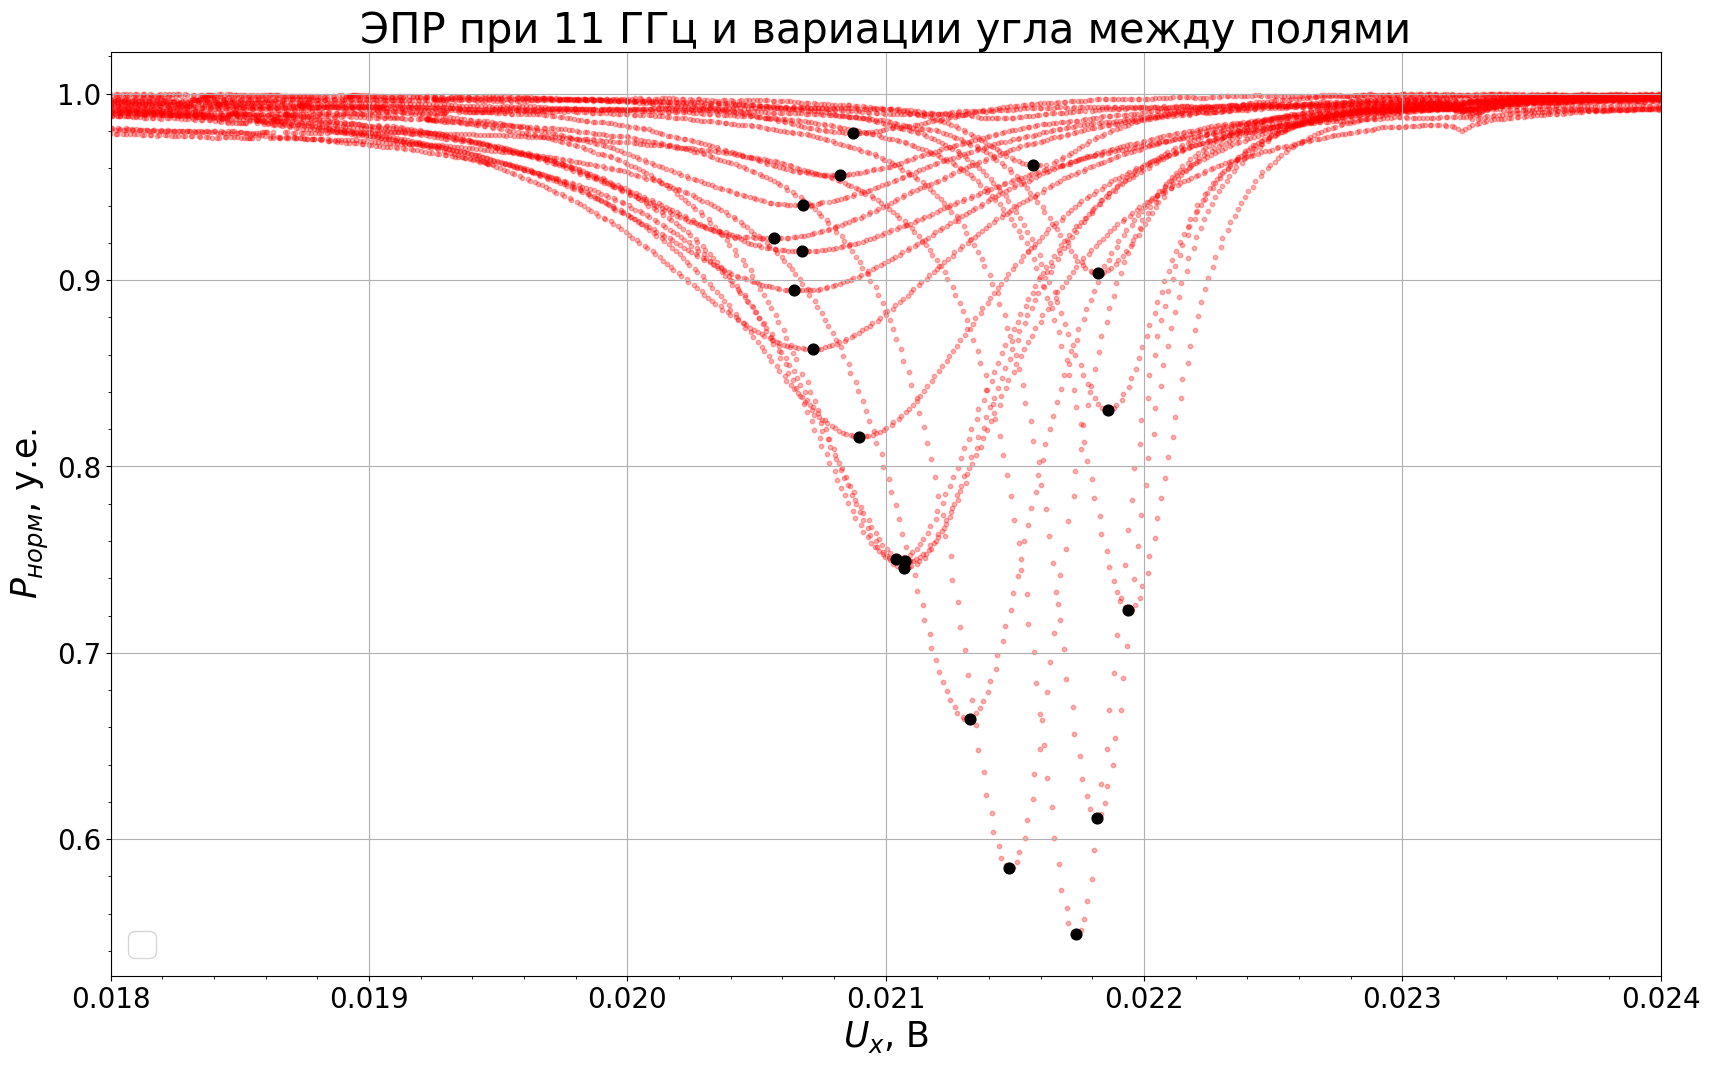

In [100]:
# Объявление путей директорий с файлами 
input_folder = '/home/golenn/EPR/data_driftless_normalised/'

plt.figure(figsize=(20, 12))
plt.title('ЭПР при 11 ГГц и вариации угла между полями', fontsize=30)
plt.ylabel(r'$P_{норм}$, у.е.', fontsize=25)
plt.xlabel(r'$U_{х}$, В', fontsize=25)

my_color = ['blue', 'red', 'green']
flag = 0
files = os.listdir(input_folder)
files.sort()
print(files)

x0 = []
y0 = []
d_val = []
b_val = []
a_val = []
names = []

for file_name in files:
    if '11GHz' in file_name:
        print(file_name)
        input_file_path = os.path.join(input_folder, file_name)    
        # Загрузка данных
        df = pd.read_csv(input_file_path, skiprows=3, sep=' ')
        df.columns = ["X_channel", "Y_channel", "II_channel", "timestamp"]
        x_data = df["X_channel"].values
        y_data = df["Y_channel"].values

    # В наших данных нет пропущенных ячеек, поэтому лишний код на проверку этого не пишем
    
        try:
            # Начальные приближения параметров
            if '14GHz' in file_name: # сильный разброс, поэтому лучше сразу отнормировать по максимуму
                #y_data /= np.max(y_data)
                #print('norm')
                clr = my_color[0]
            elif '11GHz' in file_name:
                clr = my_color[1]
            else:
                clr = my_color[2]

            # Подбор параметров
            u0_guess = (y_data[0] + y_data[len(y_data)-1])/2
            x0_guess = x_data[np.argmin(y_data)]
            initial_guess = [u0_guess, x0_guess, -1, 0.1, 0.1, 0.1]

            params, _ = curve_fit(lorentzian_driftless, x_data, y_data, p0=initial_guess)

            print(f"Fitted parameters {file_name}:")
            print(f"u0 = {params[0]:.4f}, x0 = {params[1]:.4e}, y0 = {np.min(y_data)} , k = {params[2]:.4f}, "
                f"a = {params[3]:.4f}, b = {params[4]:.4f}, d = {params[5]:.4e}")
            
            # Сбор данных
            x0.append(x_data[np.argmin(y_data)])
            y0.append(np.min(y_data))
            names.append(file_name)
            d_val.append(params[5])
            b_val.append(params[4])
            a_val.append(params[3])

            x_fit = np.linspace(min(x_data), max(x_data), 500)
            y_fit = lorentzian(x_fit, *params)

        except Exception:
            print(f'Exception raised {file_name}')
  
        # Построение графика
        plt.scatter(x_data, y_data, color='r', alpha=0.3, s=10)
        

x0_pos = []   
y0_pos = []
for i in range(len(x0)):
    if x0[i] > 0:
        x0_pos.append(x0[i])
        y0_pos.append(y0[i])


plt.scatter(x0_pos, y0_pos, color='black', s=60)
plt.legend(fontsize=25)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)
plt.minorticks_on()
plt.xlim([0.018, 0.024])
plt.savefig(fname='Angle variation 11GHz')
plt.show()


Собрали в отдельный файл данные с помощью gnuplot

In [27]:
# Сбор данных по столбцам из файла
file_path = '/home/golenn/EPR/11GHz interpolation data.csv'
 
data = pd.read_csv(file_path, sep='\t')
data.columns = ["angle", "ampl(b)", "pos(c)", "width(d)"]

angle_data = data["angle"].values
ampl_data = data["ampl(b)"].values
pos_data = data["pos(c)"].values
width_data = data["width(d)"].values

intensity_data = ampl_data * width_data


print(angle_data)
print(width_data)

[270 360 370 200 210 220 230 230 240 250 260 270 280 290 300 310 320 330
 340 350]
[0.00047  0.00022  0.00033  0.00043  0.00059  0.00069  0.00078  0.00083
 0.0008   0.00075  0.00063  0.00048  0.00036  0.00026  0.00022  0.00021
 0.000239 0.000267 0.000274 0.000299]


Построим графики интересующих угловых зависимостей

<>:19: SyntaxWarning: invalid escape sequence '\T'
<>:19: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_53801/164329264.py:19: SyntaxWarning: invalid escape sequence '\T'
  plt.scatter(angle_data, width_data, color='black', label=f'$D(\Theta)$', s=100)
/tmp/ipykernel_53801/164329264.py:7: OptimizeWarning: Covariance of the parameters could not be estimated
  params, params_cov = curve_fit(model, angle_data, width_data, p0=initial_guess)


[ 2.74889746e-04  2.61910785e-05 -2.31913280e-03 -3.50555393e-01
  4.50241265e-04]


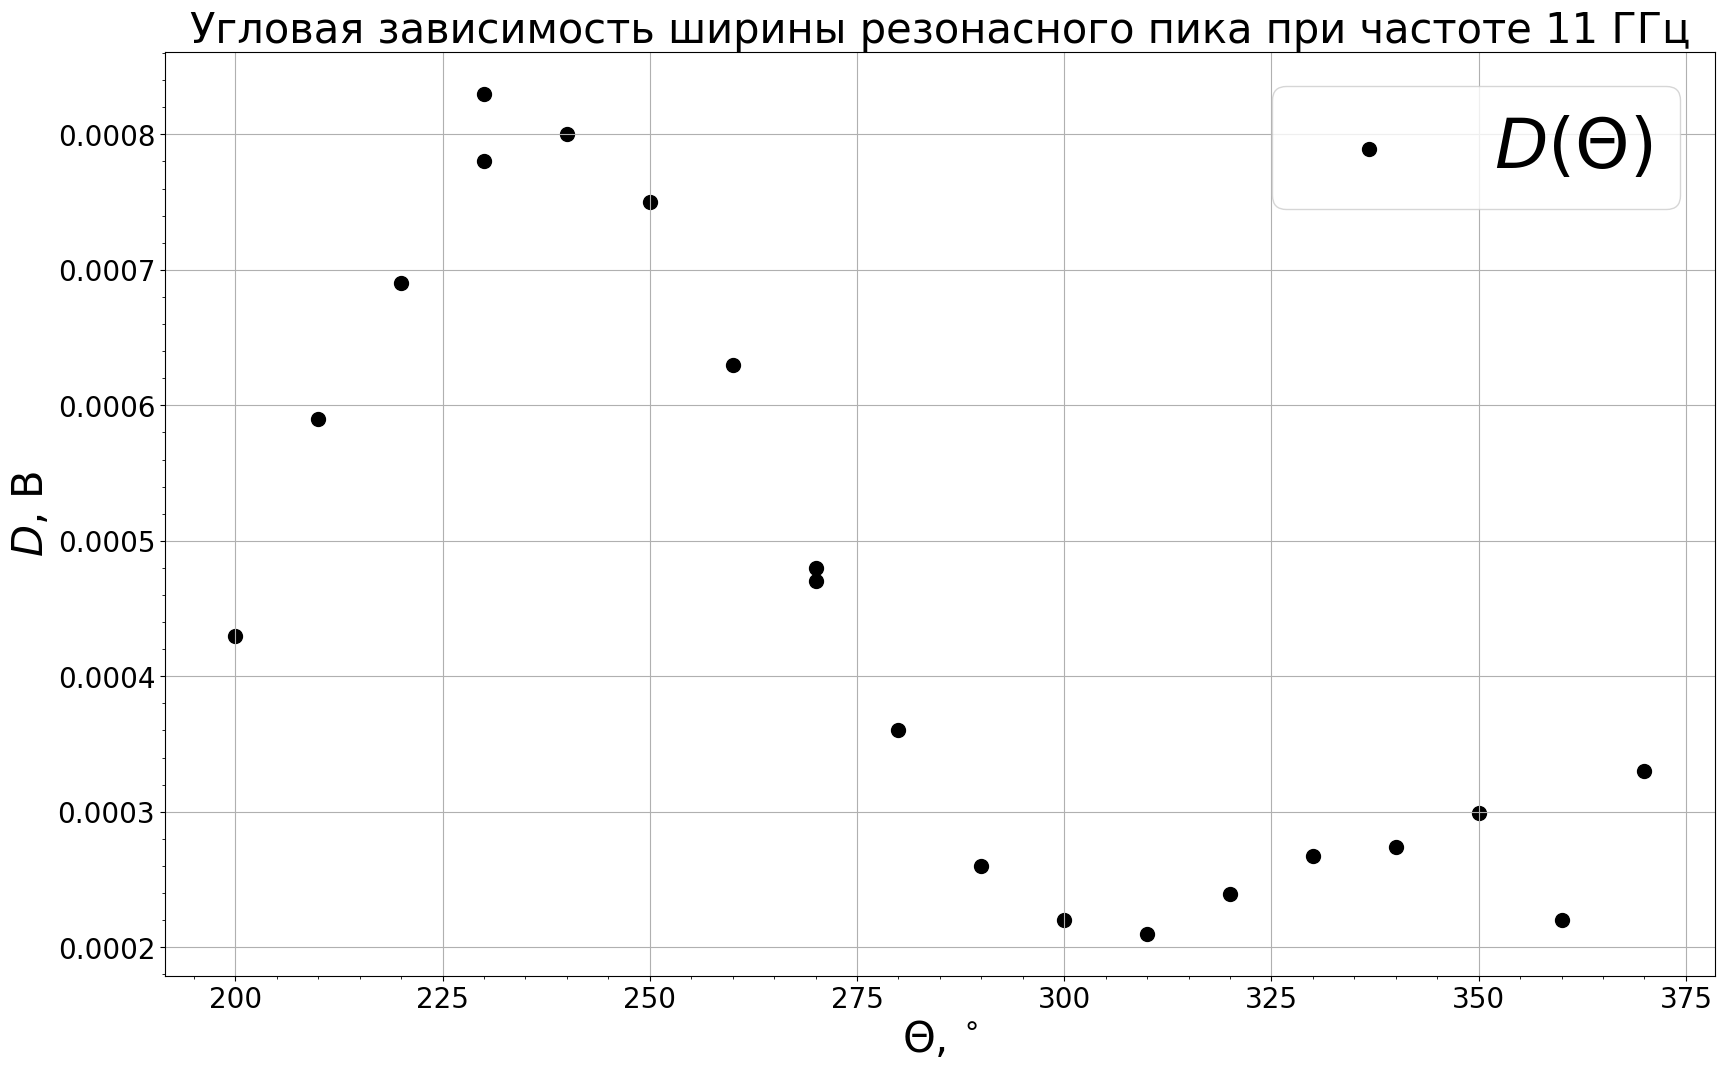

In [66]:
def model(x, a, b, c, p, d):
    return a*np.sin(2*x/360*2*np.pi + p) + b*np.cos(0.5*x/360*2*np.pi + p) + c-c+d 

x_fit = np.linspace(min(angle_data), max(angle_data), 5000)

initial_guess = [0.0004, 0.0004, 0.0004, 1, 0.0004]
params, params_cov = curve_fit(model, angle_data, width_data, p0=initial_guess)

y_fit = model(x_fit, *params)
print(params)

plt.figure(figsize=(20, 12))
plt.title('Угловая зависимость ширины резонасного пика при частоте 11 ГГц', fontsize=30)
plt.ylabel(r'$D$, В', fontsize=30)
plt.xlabel(r'$\Theta, ^\circ$', fontsize=30)

#plt.scatter(x_fit, y_fit, color='red', label=f'$D(\Theta)$', s=100)

plt.scatter(angle_data, width_data, color='black', label=f'$D(\Theta)$', s=100)
plt.legend(fontsize=50)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid()
plt.minorticks_on()


plt.savefig(fname='D(theta).png')
plt.show()

<>:28: SyntaxWarning: invalid escape sequence '\T'
<>:28: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_53801/149296196.py:28: SyntaxWarning: invalid escape sequence '\T'
  plt.scatter(angle_data, intensity_data, color='black', label=f'$I(\Theta)$', s=100)


[1.22422976e-04 1.49305862e+00]


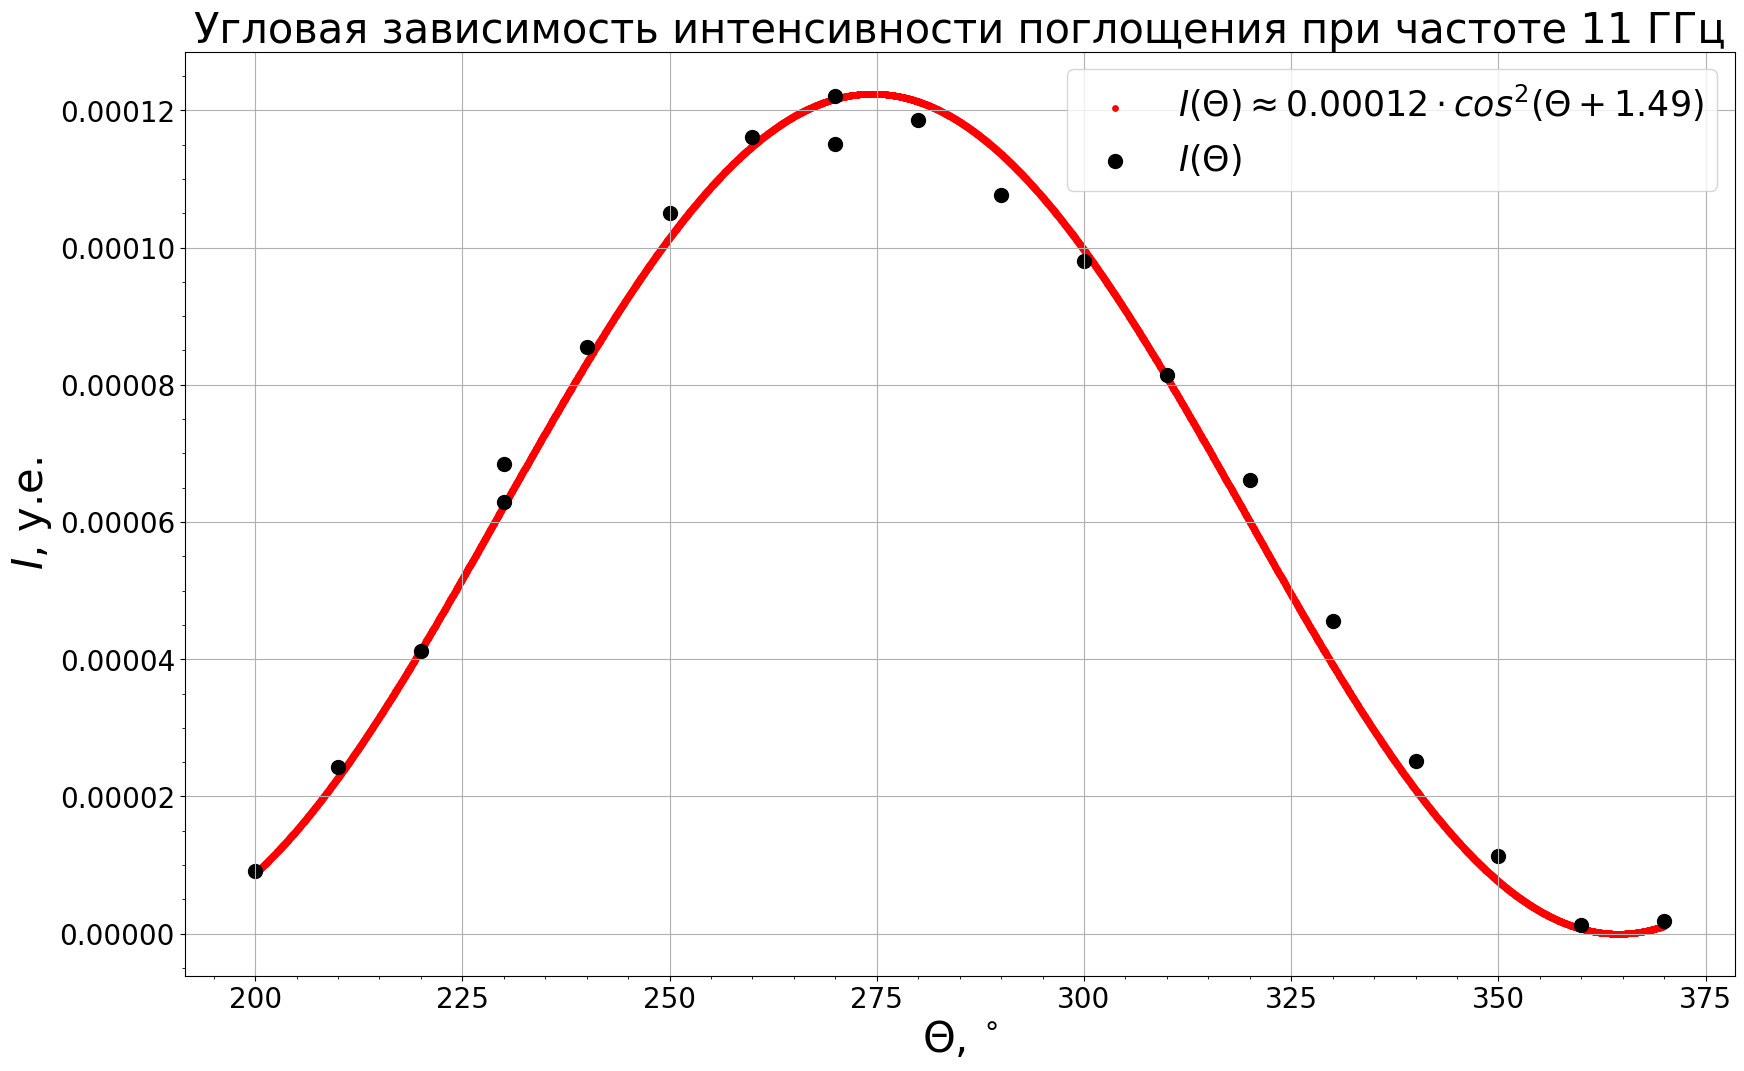

In [40]:
def model(x, a, b):
    return a*np.cos(x/360*2*np.pi + b)**2

x_fit = np.linspace(min(angle_data), max(angle_data), 5000)

initial_guess = [0.00012, 1]
params, params_cov = curve_fit(model, angle_data, intensity_data, p0=initial_guess)

y_fit = model(x_fit, *params)
print(params)


#initial_guess1 = [270, 0.00013, 4]
#params1, params_cov1 = curve_fit(lor_intens, angle_data, intensity_data, p0=initial_guess1)

#y_fit1 = lor_intens(x_fit, *params1)
#print(params1)

plt.figure(figsize=(20, 12))
plt.title('Угловая зависимость интенсивности поглощения при частоте 11 ГГц', fontsize=30)
plt.ylabel(r'$I$, у.е.', fontsize=30)
plt.xlabel(r'$\Theta, ^\circ$', fontsize=30)

plt.scatter(x_fit, y_fit, color='red', label=r'$I(\Theta) \approx 0.00012\cdot cos^2(\Theta + 1.49)$', s=15)

#plt.scatter(x_fit, y_fit1, color='blue', label=r'$I(\Theta) \approx 0.00012\cdot cos^2(\Theta + 1.49)$', s=1)

plt.scatter(angle_data, intensity_data, color='black', label=f'$I(\Theta)$', s=100)
plt.legend(fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid()
plt.minorticks_on()

plt.savefig(fname='I(theta)')
plt.show()

